In [1]:
import os
import pandas as pd
import spacy

In [2]:
PATH = "/home/bryan/Documents/Code/si630/semeval/datasets/train-articles/"

In [3]:
filenames = []
for root, dirs, files in os.walk(PATH, topdown=True):
    filenames = files

In [4]:
nlp = spacy.load("en_core_web_sm", disable=["ner"]) #can also disable components at load, nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser"])

In [5]:
texts = [] #create a single string for each doc & add to list
text_to_num = []
counter = 0
for name in filenames:
    text_to_num.append((counter,name))
    counter += 1
    with open(PATH+name) as f:
        text = f.read()
        texts.append(text)

In [6]:
%%time

docs_as_sents = []
for doc in nlp.pipe(texts): #can also disable components here (processing) using disable=["tagger", "parser", "ner"] # print(nlp.pipe_names) #can check which components of pipe are enabled
    docs_as_sents.append([sentence for sentence in doc.sents]) #produces list of lists where elements are separate sentences in doc

CPU times: user 19.5 s, sys: 5.72 s, total: 25.2 s
Wall time: 25.2 s


In [7]:
#hist of length of sentence in doc
sent_lens = []
for i in docs_as_sents:
    for j in i:
        sent_lens.append(len(j))

In [8]:
import matplotlib.pyplot as plt
import numpy as np

The mean number of words in a sentence is: 21.7


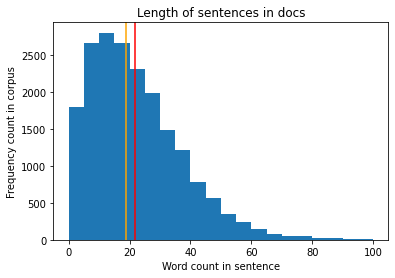

In [9]:
plt.hist(x=sent_lens, bins = 20, range = (0,100)); #excluding some positive outliers
plt.xlabel("Word count in sentence")
plt.ylabel("Frequency count in corpus")
plt.axvline(x=np.mean(sent_lens), color="r")
plt.axvline(x=np.median(sent_lens), color="orange")
plt.title(label = "Length of sentences in docs");
print(f"The mean number of words in a sentence is: {round(np.mean(sent_lens),2)}")

In [10]:
#hist of number of sentences in docs
sents_in_docs = []
for i in docs_as_sents:
    sents_in_docs.append(len(i))

The mean number of sentences in a doc is: 51.95


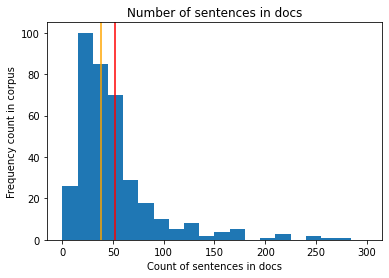

In [11]:
plt.hist(x=sents_in_docs, bins = 20, range = (0, 300)); #excluding some positive outliers
plt.xlabel("Count of sentences in docs")
plt.ylabel("Frequency count in corpus")
plt.axvline(x=np.mean(sents_in_docs), color="r")
plt.axvline(x=np.median(sents_in_docs), color="orange")
plt.title(label = "Number of sentences in docs");
print(f"The mean number of sentences in a doc is: {round(np.mean(sents_in_docs),2)}")

In [12]:
from spacy.tokens import Doc, Token, Span
# Span.set_extension("TRAIN_LABEL", default = "No_Label", force = True)
Span.set_extension("TRAIN_LABEL", default = "No_Label")

In [13]:
%%time

docs_as_docs = []
for doc in nlp.pipe(texts):
    docs_as_docs.append(doc)

CPU times: user 17.6 s, sys: 5.58 s, total: 23.2 s
Wall time: 23.2 s


In [14]:
#create list of tuples of file name/number to element num & then convert to df
MAP_NUM_TO_NAME_df = pd.DataFrame(text_to_num, columns = ["element_in_list", "filename"])

In [15]:
import re

In [16]:
MAP_NUM_TO_NAME_df["filenumber"] = MAP_NUM_TO_NAME_df.apply(lambda x: int(re.findall("\d+", x["filename"])[0]), axis=1)
MAP_NUM_TO_NAME_df = MAP_NUM_TO_NAME_df[["filenumber","filename","element_in_list"]]

In [17]:
TRAIN_LABELS = "/home/bryan/Documents/Code/si630/semeval/datasets/train-task2-TC.labels"

In [18]:
ALL_SPANS = pd.read_csv(TRAIN_LABELS, sep = "\t", header = None, names = ["filenumber","label","span_start","span_end"])

In [19]:
ALL_SPANS["span_len"] = ALL_SPANS.apply(lambda x: x["span_end"]-x["span_start"], axis=1)

In [20]:
all_spans_viz = pd.DataFrame(ALL_SPANS.groupby("label").mean()["span_len"]) #mean len of class/label  

In [21]:
temp_df = pd.DataFrame(data = ALL_SPANS["label"].value_counts()) #class/label counts

In [22]:
all_spans_viz = all_spans_viz.merge(temp_df, left_index=True, right_index=True)
all_spans_viz.rename(columns = {"label":"count"}, inplace = True)

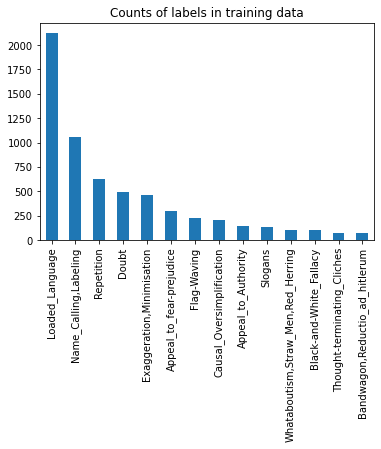

In [23]:
all_spans_viz["count"].sort_values(ascending = False).plot.bar();
plt.title("Counts of labels in training data");

In [24]:
all_spans_viz["span_len"].sort_values(ascending = False)

Appeal_to_Authority                   138.958333
Doubt                                 124.797160
Causal_Oversimplification             123.980861
Black-and-White_Fallacy               105.299065
Appeal_to_fear-prejudice               98.585034
Whataboutism,Straw_Men,Red_Herring     97.148148
Bandwagon,Reductio_ad_hitlerum         96.277778
Flag-Waving                            61.882096
Exaggeration,Minimisation              44.141631
Thought-terminating_Cliches            30.473684
Name_Calling,Labeling                  26.327032
Slogans                                25.093023
Loaded_Language                        24.486576
Repetition                             17.784219
Name: span_len, dtype: float64

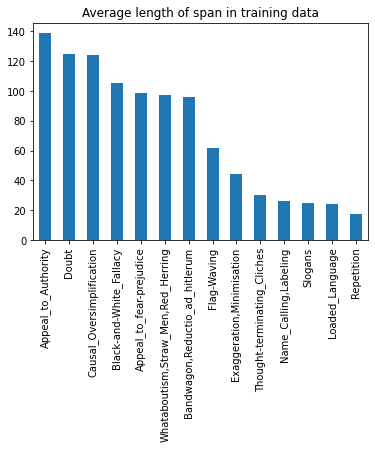

In [25]:
all_spans_viz["span_len"].sort_values(ascending = False).plot.bar();
plt.title("Average length of span in training data");

## Assign labels to positive training examples

In [26]:
ALL_SPANS_MAP = ALL_SPANS.merge(MAP_NUM_TO_NAME_df, on = "filenumber")

In [27]:
#currently there are 26 errors, mostly due to missing/wrong spans
for row in ALL_SPANS_MAP.iterrows():
    try:
        row_temp = row[1]
        docs_as_docs[row_temp["element_in_list"]].char_span(row_temp["span_start"], row_temp["span_end"])._.TRAIN_LABEL = row_temp["label"]
    except Exception as e:
        pass

# Create & label negative training spans

In [28]:
%%time

from intervaltree import Interval, IntervalTree

ALL_NEG_SPANS = []
errors = []
CONTEXT_WINDOW = 75 #size of one half of context window

# for a unique value in element_in_list
for i in ALL_SPANS_MAP["element_in_list"].unique(): #iterate through unique entries in element_in_list
    sub_df = ALL_SPANS_MAP[ALL_SPANS_MAP["element_in_list"]==i] #this is subset of main df containing only entries for the current doc
    these_intervals = [(x[1]["span_start"], x[1]["span_end"]) for x in sub_df.iterrows()] #get intervals
    this_tree = IntervalTree.from_tuples(these_intervals) #initialize tree with intervals
    
    this_doc = docs_as_docs[i]
    START_POINT = CONTEXT_WINDOW #char position we can start from # start_point = int(math.fabs(min(context_window))) 
    END_POINT = len(this_doc)-(CONTEXT_WINDOW) #char position we can work up until # end_point = len(docs_as_docs[13])-(max(max(context_window),0))
    for j in range(START_POINT, END_POINT): #for the range of possible center positions of the CONTEXT_WINDOW
        if this_tree.overlap(j, j+CONTEXT_WINDOW):
            continue
        else:
            try:
                docs_as_docs[i].char_span(j, j+CONTEXT_WINDOW)._.TRAIN_LABEL = ""
                ALL_NEG_SPANS.append((i, (j,j+CONTEXT_WINDOW)))
            except Exception as e:
                errors.append(i)

CPU times: user 4.47 s, sys: 4.9 ms, total: 4.48 s
Wall time: 4.63 s


## Create training dataframe

In [29]:
full_list = [(docs_as_docs[i[0]].char_span(i[1][0],i[1][1]).text,"No_Propaganda") for i in ALL_NEG_SPANS]

In [30]:
for i in ALL_SPANS_MAP.iterrows():
    try:
        full_list.append((docs_as_docs[i[1]["element_in_list"]].char_span(i[1]["span_start"],i[1]["span_end"]).text, i[1]["label"]))
    except Exception as e:
        pass

In [31]:
train_df = pd.DataFrame.from_records(full_list, columns =['text','label'])

In [32]:
# create new col that is binary flag of "propaganda vs no propaganda"
train_df["label_binary"] = train_df.apply(lambda x: "No_Propaganda" if x["label"]=="No_Propaganda" else "Propaganda", axis=1)

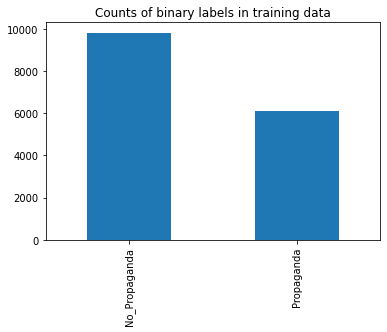

In [33]:
train_df["label_binary"].value_counts().plot.bar();
plt.title("Counts of binary labels in training data");

In [34]:
train_df["label_binary"].value_counts(normalize=True)*100

No_Propaganda    61.683827
Propaganda       38.316173
Name: label_binary, dtype: float64

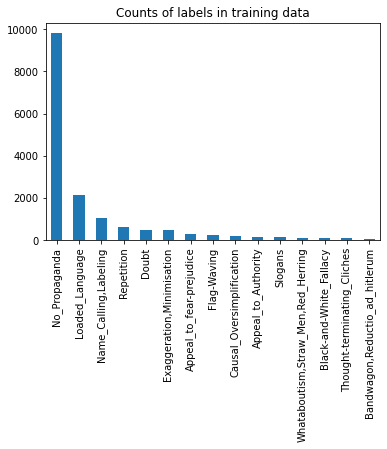

In [35]:
train_df["label"].value_counts().plot.bar();
plt.title("Counts of labels in training data");

In [36]:
train_df["label"].value_counts(normalize=True)*100

No_Propaganda                         61.683827
Loaded_Language                       13.278503
Name_Calling,Labeling                  6.617278
Repetition                             3.879960
Doubt                                  3.076344
Exaggeration,Minimisation              2.919387
Appeal_to_fear-prejudice               1.833250
Flag-Waving                            1.431441
Causal_Oversimplification              1.305876
Appeal_to_Authority                    0.891512
Slogans                                0.809895
Whataboutism,Straw_Men,Red_Herring     0.678051
Black-and-White_Fallacy                0.671773
Thought-terminating_Cliches            0.470869
Bandwagon,Reductio_ad_hitlerum         0.452034
Name: label, dtype: float64

In [37]:
import textstat

train_df["sent_count"] = train_df.apply(lambda x: textstat.sentence_count(x["text"]), axis=1)
train_df["flesch_reading"] = train_df.apply(lambda x: textstat.flesch_reading_ease(x["text"]), axis=1)
train_df["difficult_words"] = train_df.apply(lambda x: textstat.difficult_words(x["text"]), axis=1)
train_df["read_index"] = train_df.apply(lambda x: textstat.automated_readability_index(x["text"]), axis=1)
train_df["syllable_count"] = train_df.apply(lambda x: textstat.syllable_count(x["text"]), axis=1)
train_df["text_standard"] = train_df.apply(lambda x: textstat.text_standard(x["text"], float_output=True), axis=1)

train_df["text_len"] = train_df.apply(lambda x: len(x["text"]), axis=1)

In [38]:
this = round(train_df.groupby("label_binary").mean(),1)
this.T

label_binary,No_Propaganda,Propaganda
sent_count,1.2,1.1
flesch_reading,67.2,44.5
difficult_words,3.2,2.2
read_index,8.3,10.7
syllable_count,18.8,12.6
text_standard,7.8,7.9
text_len,75.0,48.3


#### Function for printing results

In [39]:
from sklearn import metrics

def evaluation_analysis(true_label,predicted): 
    '''
    return all metrics results
    '''
    print("accuracy",metrics.accuracy_score(true_label, predicted))
    print("f1 score macro",metrics.f1_score(true_label, predicted, average='macro'))     
    print("f1 score micro",metrics.f1_score(true_label, predicted, average='micro')) 
    print("precision score",metrics.precision_score(true_label, predicted, average='macro')) 
    print("recall score",metrics.recall_score(true_label, predicted, average='macro')) 
    print("hamming_loss",metrics.hamming_loss(true_label, predicted))
    print("\n")
    print("classification_report", metrics.classification_report(true_label, predicted))
    print("jaccard_similarity_score", metrics.jaccard_score(true_label, predicted, average="weighted"))

#     print("log_loss", metrics.log_loss(true_label, predicted))
    print("zero_one_loss", metrics.zero_one_loss(true_label, predicted))
#     print("AUC&ROC",metrics.roc_auc_score(true_label, predicted))
    print("matthews_corrcoef", metrics.matthews_corrcoef(true_label, predicted)) 

## Train Test Split

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df[["text", 'text_len', 'sent_count',
       'flesch_reading', 'difficult_words', 'read_index', 
              'syllable_count','text_standard']], 
    train_df["label_binary"], 
    train_size = 0.7, 
    random_state = 3, 
    shuffle = True, 
    stratify=train_df["label_binary"]) #use stratify here to ensure proportions of labels are maintained

## Transform features

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

word_vectorizer = TfidfVectorizer(strip_accents = "unicode", lowercase = True, 
                             stop_words = "english", analyzer = "word", token_pattern = "[a-z]+", smooth_idf = True, ngram_range=(1,3))

In [43]:
from sklearn.compose import ColumnTransformer

column_trans = ColumnTransformer([('tfidf', word_vectorizer, 'text')], remainder="passthrough")

train_transformed = column_trans.fit_transform(X_train)
test_transformed = column_trans.transform(X_test)

# to use just tf-idf
# train_transformed = word_vectorizer.fit_transform(X_train)
# test_transformed = word_vectorizer.transform(X_test)

### DummyClassifier

In [44]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

In [51]:
dummy = DummyClassifier(strategy = "stratified", random_state = 8)

# dummy_param_grid = [{"strategy": ["stratified", "most_frequent","prior"]
#               }]
dummy_param_grid = [{"strategy": ["stratified"]
              }]
dummy_gs = GridSearchCV(
    estimator = dummy,
    param_grid = dummy_param_grid,
    cv=10
)
dummy_gs.fit(train_transformed, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DummyClassifier(constant=None, random_state=8,
                                       strategy='stratified'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'strategy': ['stratified']}], pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [52]:
dummy_gs.best_estimator_

DummyClassifier(constant=None, random_state=8, strategy='stratified')

In [53]:
dummy_gs.cv_results_["mean_test_score"]

array([0.53323071])

In [54]:
# dummy_y_pred = dummy_gs.predict(X_test)
dummy_y_pred = dummy_gs.predict(test_transformed)

In [55]:
evaluation_analysis(y_test, dummy_y_pred)

accuracy 0.531282695124503
f1 score macro 0.5032643150432452
f1 score micro 0.531282695124503
precision score 0.5032780967902826
recall score 0.5032656895750629
hamming_loss 0.46871730487549695


classification_report                precision    recall  f1-score   support

No_Propaganda       0.62      0.62      0.62      2948
   Propaganda       0.39      0.38      0.39      1831

     accuracy                           0.53      4779
    macro avg       0.50      0.50      0.50      4779
 weighted avg       0.53      0.53      0.53      4779

jaccard_similarity_score 0.369365973514879
zero_one_loss 0.468717304875497
matthews_corrcoef 0.006543774603108817


In [56]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, dummy_y_pred, labels=["No_Propaganda","Propaganda"]).ravel()
print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = round((2*precision*recall)/(precision+recall),3)

print(f"F1: {f1}")
precision, recall

TN: 1837
FP: 1111
FN: 1129
TP: 702
F1: 0.385


(0.38720353006067293, 0.383397050791917)

> ## The best dummy classifier is one that simply predicts the most common label which is "No_Propaganda". Since it only predicts the negative class precision, recall, and F1 are all undefined for this classifier.

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
%%time

lr = LogisticRegression(n_jobs=-1)
lr_param_grid = [{"penalty":["l2","none","l1"],
              "C":[10000,1000],
                  "fit_intercept": [True, False],
#                   "class_weight": [None, "balanced"],
                  "solver": ["newton-cg","sag","saga"]
#                   "solver": ["lbfgs","liblinear", "newton-cg","sag","saga"]
              }]
lr_gs = GridSearchCV(
    estimator = lr,
    param_grid = lr_param_grid,
    cv=10
)
lr_gs.fit(train_transformed, y_train)

/home/bryan/Documents/Code/python-environments/SI630/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/bryan/Documents/Code/python-environments/SI630/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/bryan/Documents/Code/python-environments/SI630/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


CPU times: user 7.3 s, sys: 6.29 s, total: 13.6 s
Wall time: 4h 39min 9s


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [10000, 1000], 'fit_intercept': [True, False],
                          'penalty': ['l2', 'none', 'l1'],
                          'solver': ['newton-cg', 'sag', 'saga']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [90]:
lr_gs.best_params_

{'C': 10000, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}

In [91]:
lr_gs.best_estimator_

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [92]:
lr_gs.cv_results_["mean_test_score"]

array([0.91712224, 0.80025094, 0.79890565, 0.9166734 , 0.80034063,
       0.79881597,        nan,        nan, 0.79890565, 0.91505962,
       0.80025094, 0.79890565, 0.91174075, 0.80034063, 0.79890565,
              nan,        nan, 0.79890565, 0.91640459, 0.80034063,
       0.79890565, 0.9166734 , 0.80034063, 0.79890565,        nan,
              nan, 0.79881597, 0.91443165, 0.80025094, 0.79890565,
       0.91174075, 0.80025094, 0.79890565,        nan,        nan,
       0.79890565])

In [93]:
lr_y_pred = lr_gs.predict(test_transformed)

In [94]:
evaluation_analysis(y_test,lr_y_pred)

accuracy 0.9192299644277045
f1 score macro 0.9120094368242205
f1 score micro 0.9192299644277045
precision score 0.9289402905319822
recall score 0.9015254952584281
hamming_loss 0.08077003557229546


classification_report                precision    recall  f1-score   support

No_Propaganda       0.90      0.98      0.94      2948
   Propaganda       0.96      0.83      0.89      1831

     accuracy                           0.92      4779
    macro avg       0.93      0.90      0.91      4779
 weighted avg       0.92      0.92      0.92      4779

jaccard_similarity_score 0.8491977731143373
zero_one_loss 0.08077003557229545
matthews_corrcoef 0.8300131627682737


In [95]:
tn, fp, fn, tp = confusion_matrix(y_test, lr_y_pred, labels=["No_Propaganda","Propaganda"]).ravel()
print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = round((2*precision*recall)/(precision+recall),3)

print(f"F1: {f1}")

TN: 2881
FP: 67
FN: 319
TP: 1512
F1: 0.887


> # The baseline logistic regression model achieves an F1 score of 0.87 and correctly predicted 1474 instances of the positive label. The precision for the positive class is actually quite high, it seems to be suffering from low recall. The opposite is true of the negative class.

In [ ]:
best_lr = LogisticRegression(C=10000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
best_lr.fit(train_transformed, y_train)

In [ ]:
best_lr_predict = best_lr.predict(test_transformed)

In [ ]:
evaluation_analysis(y_test,best_lr_predict)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, best_lr_predict, labels=["No_Propaganda","Propaganda"]).ravel()
print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = round((2*precision*recall)/(precision+recall),3)

print(f"F1: {f1}")
precision,recall

## <span style="color:olive"> Next steps
1. Validate calculations of precision, recall, & f1
1. Create Pipeline so can adjust more aspects of steps (e.g. experimenting with more ngrams in tfidf)
1. Experiment with different/longer CONTEXT_WINDOW sizes (i.e. 100, 100+). See how that impacts negative samples.
1. Try to resolve issue with char_span failing frequently on spaCy docs
1. For spans assigned positive labels select one of the specific class labels from a multinomial (i.e. at random)